# Build a Neural Network with PyTorch

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt
from torchvision import datasets, transforms
!conda install pytorch -c pytorch -y
#!conda install helper -y
print(torch.__version__)
#print(helper.view_classify)

Solving environment: done

# All requested packages already installed.

0.4.0


## Get Dataset. 

This is provided through the torchvision package.

The code below will download the MNIST dataset, then create training and test datasets for us.

In [5]:
# Transform images into pytorch tensors, then it normalises them 
# take input (image pixel values) and bring them to the same scale.
# Makes it easier for our NN to learn.

# https://pytorch.org/docs/master/torchvision/transforms.html#torchvision.transforms.Normalize
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])

# Download and load the training data using torchvision and then apply normalisation previously defined
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

We have the training data loaded into trainloader and we make that an iterator with iter(trainloader). We'd use this to loop through the dataset for training, but here I'm just grabbing the first batch so we can check out the data. We can see below that images is just a tensor with size (64, 1, 28, 28). So, 64 images per batch, 1 color channel, and 28x28 images.

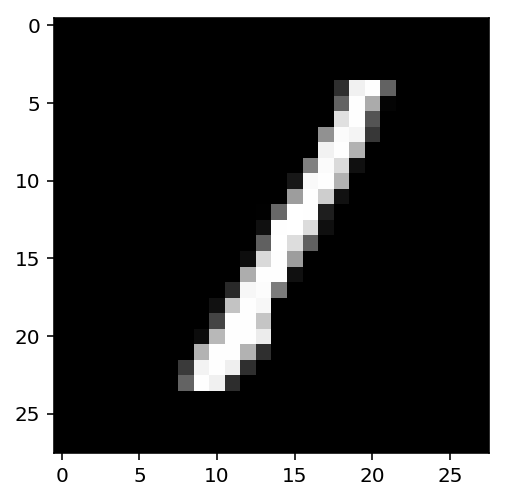

In [6]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

## Building networks with PyTorch

Here we'll use PyTorch to build a simple feedfoward network to classify the MNIST images. That is, the network will receive a digit image as input and predict the digit in the image.

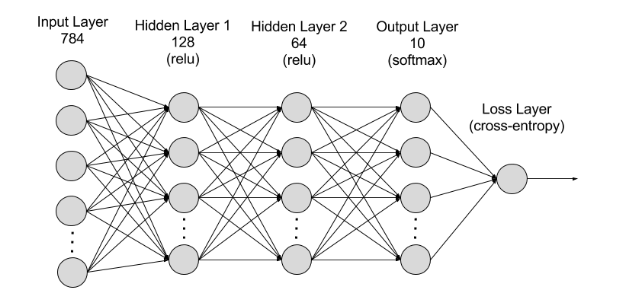

Image explanation: The input layer refers to 784 pixels (one per each pixel from input images which are 28x28px in size) being converted into vectors, which will then be fed into the input layet.

Two hidden layers, first with 128 units (using relu as activation function) and second layer using 64 units.

Output layer refers to 10 of all possible values, which will use a softmax function ($logsumexp(a)=\log(\sum{\exp^{a_i}})$) that would give us the final probability value for each of the units, where the highest float (closer to 1) would ideally refer to the correct class prediction.

We use cross-entropy to determine if our model is good or bad, by calculating the negative of the logarithm of each of the probabilities. (The sum of these values is called cross-entropy). The lowest the cross-entropy the more accurate our model is.

To build a neural network with PyTorch, you use the ```torch.nn``` module. The network itself is a class inheriting from ```torch.nn.Module```. You define each of the operations separately, like ```nn.Linear(784, 128)``` for a fully connected linear layer with 784 inputs and 128 units.

The class needs to include a ```forward``` method that implements the forward pass through the network. In this method, you pass some input tensor x through each of the operations you defined earlier. The ```torch.nn``` module also has functional equivalents for things like ReLUs in ```torch.nn.functional```. This module is usually imported as ```F```. Then to use a ReLU activation on some layer (which is just a tensor), you'd do ```F.relu(x)```. Below are a few different commonly used activation functions.

![image.png](attachment:image.png)

So, for this network, I'll build it with three fully connected layers, then a softmax output for predicting classes. The softmax function is similar to the sigmoid in that it squashes inputs between 0 and 1, but it's also normalized so that all the values sum to one like a proper probability distribution.

In [7]:
from torch import nn
from torch import optim
import torch.nn.functional as F

In [8]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        # all networks created in Pytorch using nn.module must have a forward method
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Initializing weights and biases

The weights and such are automatically initialized, but it's possible to customize how they are initialized. The weights and biases are tensors attached to the defined layer, you can get them with ```model.fc1.weight``` for instance.


In [9]:
print(model.fc1.weight)
print(model.fc1.bias)

Parameter containing:
tensor([[ 2.2108e-03, -2.1001e-02,  3.5354e-02,  ...,  2.9438e-02,
          2.9294e-02, -1.9340e-02],
        [-1.6718e-02,  2.5662e-02,  8.8734e-03,  ...,  2.5562e-03,
         -3.0465e-02,  1.7538e-02],
        [-3.1554e-02, -6.7055e-03, -1.6212e-02,  ...,  1.3407e-02,
         -8.4080e-03, -1.7668e-02],
        ...,
        [-2.8727e-02,  1.2654e-02,  1.7748e-02,  ...,  4.2919e-04,
          2.7108e-02,  2.8439e-02],
        [-1.6552e-02, -1.3732e-02, -7.6667e-04,  ..., -3.5707e-02,
         -1.6651e-02, -1.0565e-02],
        [-2.5750e-02, -3.9201e-03,  3.1848e-03,  ..., -1.4637e-02,
         -3.2009e-02, -1.4629e-02]])
Parameter containing:
tensor(1.00000e-02 *
       [-0.9376,  1.6503,  0.9840,  0.7672,  3.5676,  1.6021, -1.9568,
         1.3001, -2.5423, -2.7366, -2.5950,  2.5437,  1.3832, -2.8782,
        -2.3693, -2.0063,  2.9992,  1.7750,  3.3916, -1.9294,  2.8984,
        -0.5918,  1.2957, -1.9811, -0.7142, -0.1933, -0.7058, -1.3038,
        -1.6126, -0

For custom initialization, we want to modify these tensors in place. These are actually autograd Variables, so we need to get back the actual tensors with model.fc1.weight.data. Once we have the tensors, we can fill them with zeros (for biases) or random normal values.


In [10]:
# Set biases to all zeros
model.fc1.bias.data.fill_(0)

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [11]:
# sample from random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[ 2.0422e-02, -7.0236e-03,  1.6901e-02,  ..., -4.5149e-03,
          1.7160e-02, -4.0965e-03],
        [ 1.7121e-04,  2.3493e-02,  7.3980e-03,  ..., -8.9758e-03,
         -5.7116e-03, -2.2529e-02],
        [ 9.3627e-03, -9.1772e-04,  2.4894e-03,  ...,  1.8333e-02,
          1.1008e-02, -8.8550e-03],
        ...,
        [ 1.1575e-02,  1.4202e-02,  1.5223e-02,  ..., -4.3385e-03,
         -1.4986e-02, -1.2183e-02],
        [-5.8661e-03, -1.2467e-02, -2.0955e-02,  ...,  1.0291e-02,
          1.2815e-02,  4.5174e-03],
        [-8.0216e-03,  1.0573e-02, -1.1425e-02,  ..., -1.5052e-03,
          1.6507e-02,  2.3867e-03]])

#### Forward Pass

Now that we have a network, let's see what happens when pass in an image. This is called the forward pass. 

During this step the image data gets converted into a tensor, then passes through all the operations defined by the network architecture.

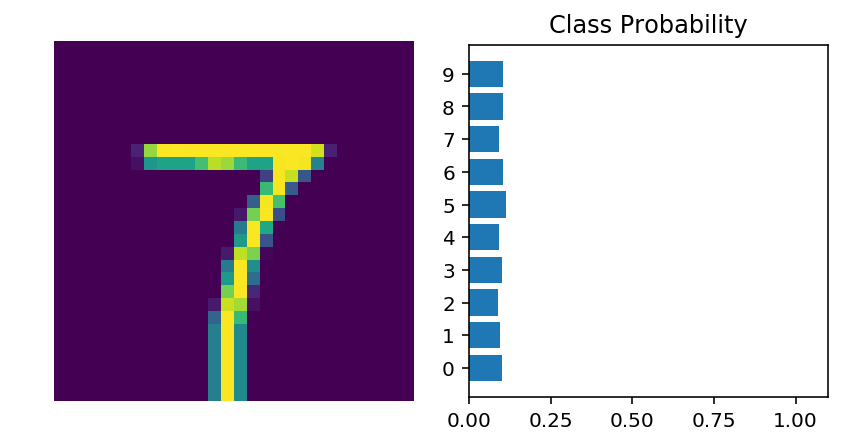

In [12]:
# Grab some data 
dataiter = iter(trainloader)
# Get the images and their labels
images, labels = dataiter.next()


# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to not automatically get batch size

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:])

img = images[img_idx]
# custom made helper function to view the images
helper.view_classify(img.view(1, 28, 28), ps)

Our network still has no idea what the digit is, as we still haven't trained it, all the weights are random.

Another way we can build networks using Pytorch, where a tensor is passed sequantial through operations is by using ```nn.Sequential```.

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax()
)


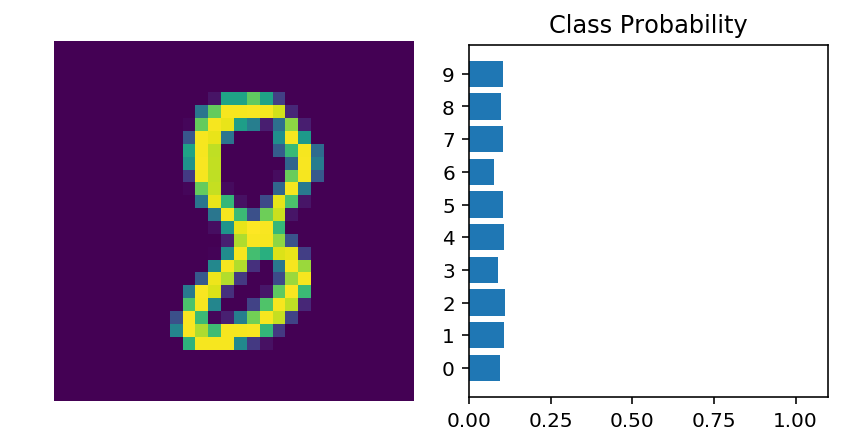

In [14]:
# This is the same network as above but in less lines of code.

input_size = 784
hidden_size = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_size[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_size[0], hidden_size[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_size[1], output_size),
                      nn.Softmax(dim=1)
                     )
print(model)

# Grab some data 
dataiter = iter(trainloader)
# Get the images and their labels
images, labels = dataiter.next()


# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to not automatically get batch size

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:])

img = images[img_idx]
# custom made helper function to view the images
helper.view_classify(img.view(1, 28, 28), ps)

when using sequential module you can also pass in an OrderedDict to name each layer and operation. Note that a dictionary keyos must be unique, so each operation must have a different name.

In [21]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
             ('fc1', nn.Linear(input_size, hidden_size[0])),
             ('relu1', nn.ReLU()),
             ('fc2', nn.Linear(hidden_size[0], hidden_size[1])),
             ('relu2', nn.ReLU()),
             ('output', nn.Linear(hidden_size[1], output_size)),
             ('softmax', nn.Softmax(dim=1))
]))
model.fc2

images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 400)
ps = model.forward(images[0,:])
helper.view_classify(images[0].view(1, 28, 28), ps)

Linear(in_features=128, out_features=64, bias=True)

*Exercise*: Build a network to classify the MNIST images with three hidden layers. Use 400 units in the first hidden layer, 200 units in the second layer, and 100 units in the third layer. Each hidden layer should have a ReLU activation function, and use softmax on the output layer.

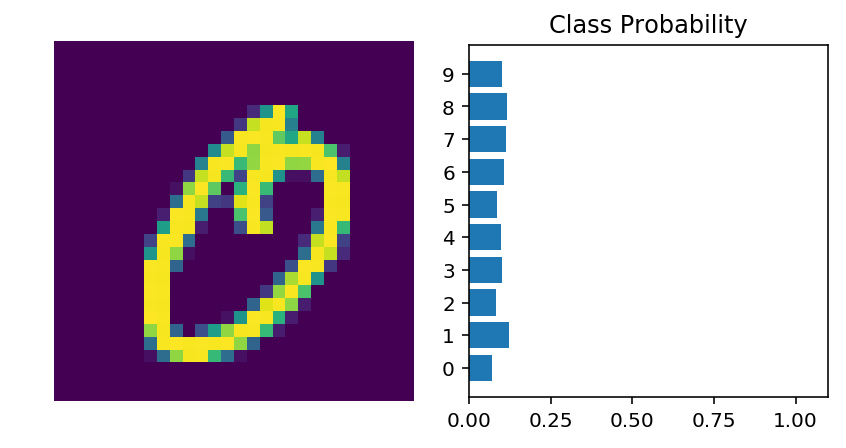

In [27]:
model = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(400, 200)),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(200, 100)),
    ('relu2', nn.ReLU()),
    ('fc3', nn.Linear(100,10)),
    ('relu3', nn.ReLU()),
    ('output', nn.Linear(10, 10)),
    ('softmax', nn.Softmax(dim=1))
]))

images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 400)
ps = model.forward(images[0,:])
helper.view_classify(images[0].view(1, 20, 20), ps)